In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [10]:
len(unique_tokens)

2162

In [11]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [12]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [13]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [14]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [15]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [16]:
np.mean([len(i) for i in padded_sentences])

12.0

In [17]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [18]:
images.shape

(3840, 224, 224, 3)

# Simple model without additional features, transfer learning and attention

In [19]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [69]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, image_shape=(224,224,3)):
        super(ConvEncoder, self).__init__()
        self.input_conv = tf.keras.layers.Conv2D(filters=128, kernel_size=7, input_shape=image_shape, activation='relu',
                           padding='same', name='input_conv', strides=(1,1))
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu',
                               padding='same', name='conv1', strides=(2,2))
        self.batch_norm1 =  tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu',
                               padding='same', name='conv2', strides=(2,2))
        self.batch_norm2 =  tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu',
                               padding='same', name='conv3', strides=(2,2))
        self.batch_norm3 =  tf.keras.layers.BatchNormalization()

        self.conv4 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu',
                               padding='same', name='conv4', strides=(2,2))
        self.batch_norm4 =  tf.keras.layers.BatchNormalization()

        self.conv5 = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu',
                               padding='same', name='conv5', strides=(2,2))
        self.batch_norm5 =  tf.keras.layers.BatchNormalization()
        self.conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu',
                               padding='same', name='conv6', strides=(2,2))
        self.batch_norm6 =  tf.keras.layers.BatchNormalization()
       
        self.flatten = tf.keras.layers.Flatten(name='final_code')
    
    def call(self, input):
        conv1_out = self.batch_norm1(self.conv1(self.input_conv(input)))
        conv2_out = self.batch_norm2(self.conv2(conv1_out))
        conv3_out = self.batch_norm3(self.conv3(conv2_out))
        conv4_out = self.batch_norm4(self.conv4(conv3_out))
        conv5_out = self.batch_norm5(self.conv5(conv4_out))
        conv6_out = self.batch_norm6(self.conv6(conv4_out))
        result = [self.flatten(conv5_out),self.flatten(conv6_out)]
        return result

In [70]:
conv_encoder = ConvEncoder()

In [71]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



### LSTM model

In [72]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None):
        super(LSTMDecoder, self).__init__()
        if not (embeddings is None):
            self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=128, name='embeddings',
                                                   weights=[embeddings])
        else:
            self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=128, name='embeddings'
                                                   )
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.embeddings(input)
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [73]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1])

### Training

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)


In [77]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [78]:
def loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return loss_

In [79]:
@tf.function
def train_step(image, target, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

            batched_loss.append(loss_function(target[:, t], result))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [80]:
@tf.function
def evaluate(image, target, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

        batched_loss.append(loss_function(target[:, t], result))

    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)


    return loss, perplexity

In [31]:
train_images, val_images, train_sequences, val_sequences =  train_test_split(images, indexed, test_size=0.2, random_state=10)

In [32]:
val_images, test_images, val_sequences, test_sequences =  train_test_split(val_images, val_sequences, test_size=0.5, random_state=10)

In [33]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [34]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [35]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [36]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size))

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size))


In [37]:
train_images.shape, train_sequences.shape, train_length.shape

((48, 64, 224, 224, 3), (48, 64, 12), (48, 64))

In [38]:
val_images.shape, val_sequences.shape, val_length.shape

((6, 64, 224, 224, 3), (6, 64, 12), (6, 64))

In [39]:
test_images.shape, test_sequences.shape, test_length.shape

((6, 64, 224, 224, 3), (6, 64, 12), (6, 64))

In [40]:
!pip install tqdm

     |████████████████████████████████| 75 kB 6.1 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [81]:
from tqdm import tqdm

In [82]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length in zip(val_images,val_sequences,val_length):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

48it [01:28,  1.83s/it]


Finished epoch 0; Train loss : 7.509893417358398; Train perplexity : 2442.952880859375


0it [00:00, ?it/s]

Validation loss : 6.483309268951416; Validation perplexity : 663.464111328125


48it [01:13,  1.53s/it]


Finished epoch 1; Train loss : 5.892862796783447; Train perplexity : 376.138671875


0it [00:00, ?it/s]

Validation loss : 5.536550998687744; Validation perplexity : 256.8623962402344


48it [01:12,  1.51s/it]


Finished epoch 2; Train loss : 5.160371780395508; Train perplexity : 177.43470764160156


0it [00:00, ?it/s]

Validation loss : 4.9978814125061035; Validation perplexity : 150.0500946044922


48it [01:12,  1.50s/it]


Finished epoch 3; Train loss : 4.689764499664307; Train perplexity : 110.46749114990234


0it [00:00, ?it/s]

Validation loss : 4.648016452789307; Validation perplexity : 106.0543212890625


48it [01:12,  1.51s/it]


Finished epoch 4; Train loss : 4.356202125549316; Train perplexity : 79.11104583740234


0it [00:00, ?it/s]

Validation loss : 4.398669719696045; Validation perplexity : 82.90151977539062


48it [01:12,  1.51s/it]


Finished epoch 5; Train loss : 4.103840351104736; Train perplexity : 61.482208251953125


0it [00:00, ?it/s]

Validation loss : 4.213232517242432; Validation perplexity : 69.03985595703125


48it [01:12,  1.51s/it]


Finished epoch 6; Train loss : 3.905616521835327; Train perplexity : 50.437442779541016


0it [00:00, ?it/s]

Validation loss : 4.070827484130859; Validation perplexity : 59.99813461303711


48it [01:12,  1.52s/it]


Finished epoch 7; Train loss : 3.7452869415283203; Train perplexity : 42.970882415771484


0it [00:00, ?it/s]

Validation loss : 3.95889949798584; Validation perplexity : 53.725372314453125


48it [01:12,  1.52s/it]


Finished epoch 8; Train loss : 3.6126410961151123; Train perplexity : 37.63102722167969


0it [00:00, ?it/s]

Validation loss : 3.8703014850616455; Validation perplexity : 49.225704193115234


48it [01:13,  1.52s/it]


Finished epoch 9; Train loss : 3.499281644821167; Train perplexity : 33.59304428100586


0it [00:00, ?it/s]

Validation loss : 3.7988827228546143; Validation perplexity : 45.8774528503418


48it [01:13,  1.52s/it]


Finished epoch 10; Train loss : 3.4014394283294678; Train perplexity : 30.45234489440918


0it [00:00, ?it/s]

Validation loss : 3.7400147914886475; Validation perplexity : 43.28416061401367


48it [01:13,  1.53s/it]


Finished epoch 11; Train loss : 3.3148739337921143; Train perplexity : 27.917882919311523


0it [00:00, ?it/s]

Validation loss : 3.692286491394043; Validation perplexity : 41.27370834350586


48it [01:13,  1.53s/it]


Finished epoch 12; Train loss : 3.2371666431427; Train perplexity : 25.82045555114746


0it [00:00, ?it/s]

Validation loss : 3.6544418334960938; Validation perplexity : 39.78352355957031


48it [01:13,  1.53s/it]


Finished epoch 13; Train loss : 3.1662635803222656; Train perplexity : 24.046579360961914


0it [00:00, ?it/s]

Validation loss : 3.6219279766082764; Validation perplexity : 38.52601623535156


48it [01:13,  1.53s/it]


Finished epoch 14; Train loss : 3.1002607345581055; Train perplexity : 22.50267791748047


0it [00:00, ?it/s]

Validation loss : 3.596338987350464; Validation perplexity : 37.57813262939453


48it [01:13,  1.53s/it]


Finished epoch 15; Train loss : 3.039780855178833; Train perplexity : 21.17677116394043


0it [00:00, ?it/s]

Validation loss : 3.57414174079895; Validation perplexity : 36.767459869384766


48it [01:13,  1.53s/it]


Finished epoch 16; Train loss : 2.98107647895813; Train perplexity : 19.961156845092773


0it [00:00, ?it/s]

Validation loss : 3.5571367740631104; Validation perplexity : 36.18963623046875


48it [01:13,  1.53s/it]


Finished epoch 17; Train loss : 2.924954414367676; Train perplexity : 18.866262435913086


0it [00:00, ?it/s]

Validation loss : 3.5434410572052; Validation perplexity : 35.705650329589844


48it [01:13,  1.53s/it]


Finished epoch 18; Train loss : 2.872206449508667; Train perplexity : 17.890663146972656


0it [00:00, ?it/s]

Validation loss : 3.530902147293091; Validation perplexity : 35.2631721496582


48it [01:13,  1.53s/it]


Finished epoch 19; Train loss : 2.8208882808685303; Train perplexity : 16.992712020874023


0it [00:00, ?it/s]

Validation loss : 3.520528554916382; Validation perplexity : 34.928585052490234


48it [01:13,  1.53s/it]


Finished epoch 20; Train loss : 2.7717552185058594; Train perplexity : 16.176464080810547


0it [00:00, ?it/s]

Validation loss : 3.5150296688079834; Validation perplexity : 34.76834487915039


48it [01:13,  1.53s/it]


Finished epoch 21; Train loss : 2.7225606441497803; Train perplexity : 15.393942832946777


0it [00:00, ?it/s]

Validation loss : 3.5139477252960205; Validation perplexity : 34.73109817504883


48it [01:13,  1.53s/it]


Finished epoch 22; Train loss : 2.6746585369110107; Train perplexity : 14.669265747070312


0it [00:00, ?it/s]

Validation loss : 3.50579833984375; Validation perplexity : 34.53767395019531


48it [01:13,  1.53s/it]


Finished epoch 23; Train loss : 2.6285879611968994; Train perplexity : 14.003602027893066


0it [00:00, ?it/s]

Validation loss : 3.506962537765503; Validation perplexity : 34.6440544128418


48it [01:13,  1.53s/it]


Finished epoch 24; Train loss : 2.5814716815948486; Train perplexity : 13.358352661132812


0it [00:00, ?it/s]

Validation loss : 3.515443801879883; Validation perplexity : 34.9218635559082
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


48it [01:13,  1.53s/it]


Finished epoch 25; Train loss : 2.548760175704956; Train perplexity : 12.923888206481934


0it [00:00, ?it/s]

Validation loss : 3.4886207580566406; Validation perplexity : 33.98042678833008


48it [01:13,  1.53s/it]


Finished epoch 26; Train loss : 2.5333869457244873; Train perplexity : 12.724677085876465


0it [00:00, ?it/s]

Validation loss : 3.4874322414398193; Validation perplexity : 33.93378829956055


48it [01:13,  1.53s/it]


Finished epoch 27; Train loss : 2.5261714458465576; Train perplexity : 12.632513999938965


0it [00:00, ?it/s]

Validation loss : 3.4866256713867188; Validation perplexity : 33.91030502319336


48it [01:13,  1.53s/it]


Finished epoch 28; Train loss : 2.519904851913452; Train perplexity : 12.553013801574707


0it [00:00, ?it/s]

Validation loss : 3.486400842666626; Validation perplexity : 33.90556716918945


48it [01:13,  1.53s/it]


Finished epoch 29; Train loss : 2.5140364170074463; Train perplexity : 12.479117393493652
Validation loss : 3.4863851070404053; Validation perplexity : 33.90739059448242


# Viewing and saving results

In [83]:
df = pd.DataFrame()
model_name = 'conv_lstm_enc_dec'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

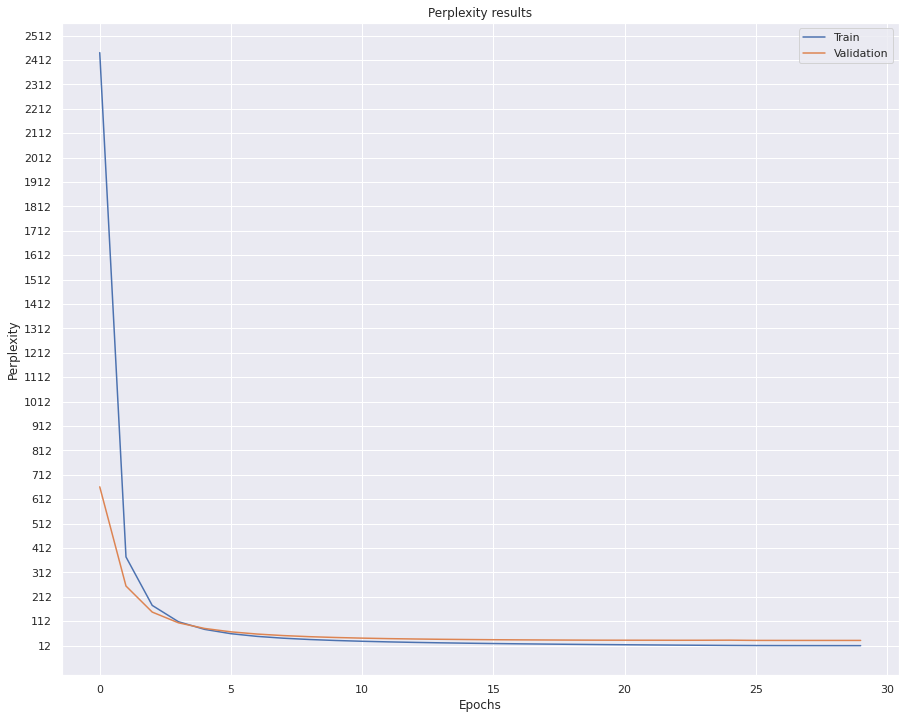

In [85]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

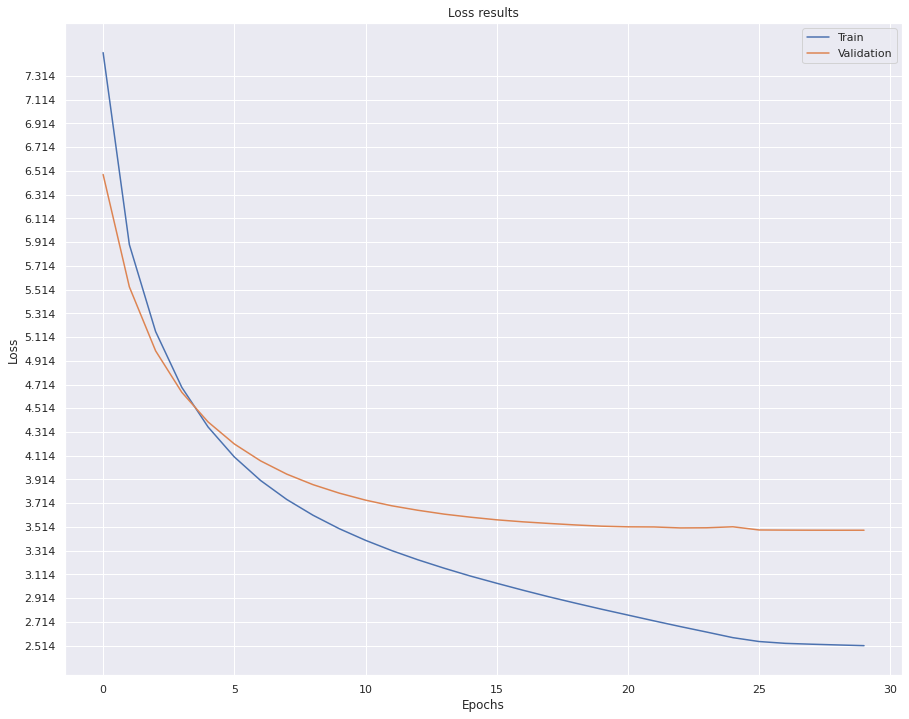

In [86]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input):
        initial_state = self.encoder(np.expand_dims(input, axis=0))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [89]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state= self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [90]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [91]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [92]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [93]:
images.shape

(3840, 224, 224, 3)

In [98]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

the woman is hugging the other woman


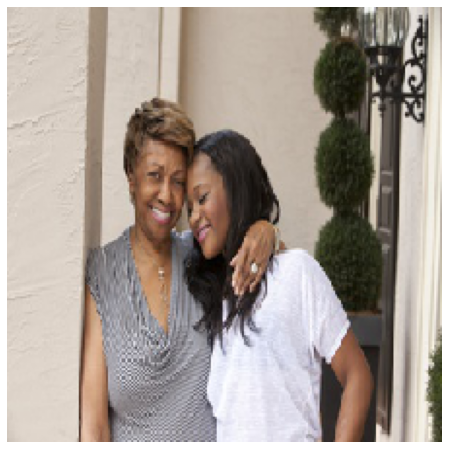

In [99]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [100]:
predict(sample, greedy_decoder, inverse_vocab)

'the man is trying to shoot somebody'

In [101]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

'the man is trying to shoot somebody'

In [102]:
predict(sample, beam_decoder, inverse_vocab, beam_size=7)

'the man is flirting with the woman'

In [103]:
predict(sample, beam_decoder, inverse_vocab, beam_size=12)

'the man is flirting with the woman'

# Blue score calculation

In [104]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [105]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [06:59<00:00, 69.97s/it]


In [106]:
test_predictions = [i.split(' ') for i in test_predictions]

In [107]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [108]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [109]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.028331378705145415


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [110]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.2325823926219359


In [111]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.10221963452944


In [112]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.04748696683818398


In [113]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.024632482207233047


In [114]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.028331378705145415


In [115]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,2442.952881,663.464111,7.509893,6.483309,2.833138,23.258239,10.221963,4.748697,2.463248,2.833138
1,376.138672,256.862396,5.892863,5.536551,2.833138,23.258239,10.221963,4.748697,2.463248,2.833138
2,177.434708,150.050095,5.160372,4.997881,2.833138,23.258239,10.221963,4.748697,2.463248,2.833138
3,110.467491,106.054321,4.689764,4.648016,2.833138,23.258239,10.221963,4.748697,2.463248,2.833138
4,79.111046,82.901520,4.356202,4.398670,2.833138,23.258239,10.221963,4.748697,2.463248,2.833138


In [116]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [117]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [118]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))